<a href="https://colab.research.google.com/github/harshchandrakar/Body-Movement-Comparison-with-Mediapipe/blob/main/MT2024054.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import pandas as pd
import numpy as np
import seaborn as sns
from joblib import Parallel, delayed

In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
# reading the data from drive storage

df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/bottle.csv")
df1 = df.sample(n=200000, random_state=42)

<ipython-input-17-6331c566c4b4>:3: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(r"/content/drive/MyDrive/Colab Notebooks/bottle.csv")


## Exploratory data analysis

# Insight Class description
####dataShape: to get shape of the data
####dataType: gives data type of each column in the dataset
####count_missing(col) : counts number of missing data in a given col (Column).
####dataMissingPercentage(): finds missing percentage of each column.
####deleteColumns(threshold) : delete all the columns which have missing percent less than given threshold.
####calculateCorrelation() : creates correlation matrix between columns.
####displayCorrelation() : dislpay correlation using heatmap.
####removeOutliersIQR() : using interquartile range delete all the outliers from the numerical columns.
####deleteRow(column): for a given column delete all the null data points.
####filterColumnsByCorrelation(target,threshold, realtion) : delete all the columns on the basis of given threshold for a target column and relation .
####describe() : it is used to describe data by giving following for each column:-
        * mean
        * median
        * mode
        * max
        * min
        * Q1 (quartile for 0.25)
        * Q2 (quartile for 0.5)
        * Q3 (quartilr for 0.75)
        * uniques for "object type data columns

In [18]:
class Insights:

  def __init__ (self,df1):
    self.df =df1
    self.results = None
    self.corr_mat =None

  def dataShape(self):
    print(f"No. of rows: {self.df.shape[0]} \nNo. of Columns: {self.df.shape[1]} \n")

  def dataTypes(self):
    self.results = self.df.dtypes.to_frame(name="data_type")
    return self.results

  def count_missing(self, col):
        count = 0
        for i, row in self.df.iterrows():
            if pd.isna(row[col]):
                count += 1
        return col, count

  def dataMissingPercentage(self):
    if self.results is None :
      self.dataTypes()
    self.results["missing_percent"] =None
    #columns = .to_list()
    for col in self.df.columns:
      count=0
      for i,row in self.df.iterrows():
        if(pd.isna(row[col])):
          count+=1
      self.results.at[col,"missing_percent"] =(count*100)/self.df.shape[0]
    return self.results

  def deleteColumns(self,threshold):
    for col in self.df.columns:
      if (self.results.at[col,"missing_percent"] >threshold):
        self.df.drop(columns=[col],inplace=True)
    self.dataShape()
    self.dataTypes()
    return self.df

  def calculateCorrelation(self):
      numeric_col = self.df.dtypes[self.df.dtypes != 'object'].index.to_list()
      #initialization of dictionary
      corr_mat = {col:{col1:0 for col1 in numeric_col} for col in numeric_col}

      for i in range(len(numeric_col)):
        for j in range(i,len(numeric_col)):

          col1 = numeric_col[i]
          col2 = numeric_col[j]

          m1 = self.df[col1].mean()
          m2 = self.df[col2].mean()

          cov = ((self.df[col1]-m1)*(self.df[col2]-m2)).mean()

          std1= self.df[col1].std()
          std2 = self.df[col2].std()

          correlation = cov/(std1*std2)

          corr_mat[col1][col2] = correlation
          corr_mat[col2][col1] =correlation
      return corr_mat

  def displayCorrelation(self):
      corr_mat = self.calculateCorrelation()
      self.corr_mat = corr_mat
      df1 = pd.DataFrame(corr_mat)
      sns.heatmap(df1.round(2),annot=True,cmap='coolwarm', vmin=-1, vmax=1)
  def removeOutliersIQR(self):
      for col in self.df.columns:
          if (df[col].dtype == "object"):
            continue
          Q1 = self.df[col].quantile(0.25)
          Q3 = self.df[col].quantile(0.75)
          IQR = Q3 - Q1

          lower_bound = Q1 - 1.5 * IQR
          upper_bound = Q3 + 1.5 * IQR
          # keeping only those rows which are greater than or equal to lower_bound and less than equal to upper_bound
          self.df = self.df[(self.df[col] >= lower_bound) & (self.df[col] <= upper_bound)]

      return self.df

  def deleteRow(self,column):
    for i,val in self.df[column].items():
      if pd.isna(val):
        self.df.drop(i,inplace=True)
    self.df.reset_index(drop=True,inplace=True)
    return self.df
  def filterColumnsByCorrelation(self,target,threshold, realtion):
    for key,val in self.corr_mat[target].items():
      if key == target :
        continue
      if  realtion == False and abs(val) <= abs(threshold) :
        self.df.drop(columns=[key],inplace=True)
      if  realtion == True and val >= threshold :
        self.df.drop(columns=[key],inplace=True)
    return self.df
  def describe(self):

    self.results["mean"] =None
    self.results["median"] =None
    self.results["mode"] =None
    self.results["min"] =None
    self.results["Q1"] =None
    self.results["Q2"] =None
    self.results["Q3"] =None
    self.results["max"] =None
    self.results["uniques"] =None
    for col in data.results.index:
      if col not in self.df.columns:
        self.results.drop(index=col, inplace=True)
        continue
      else:

        if (self.df[col].dtypes != 'object'):
            self.results.at[col,"mean"] = self.df[col].mean()
            self.results.at[col,"median"] = self.df[col].median()
            self.results.at[col,"mode"] = self.df[col].mode()[0]
            self.results.at[col,"Q1"] = self.df[col].quantile(0.25)
            self.results.at[col,"Q2"] = self.df[col].quantile(0.50)
            self.results.at[col,"Q3"] =self.df[col].quantile(0.75)
            self.results.at[col,"min"] = self.df[col].min()
            self.results.at[col,"max"] = self.df[col].max()
        else:
            self.results.at[col,"uniques"] = self.df[col].nunique()
    return self.results





In [19]:
data = Insights(df1)
data.dataShape()
data.dataMissingPercentage()

No. of rows: 200000 
No. of Columns: 74 



,data_type,missing_percent
Cst_Cnt,int64,0.0
Btl_Cnt,int64,0.0
Sta_ID,object,0.0
Depth_ID,object,0.0
Depthm,int64,0.0
...,...,...
TA1,float64,99.7625
TA2,float64,99.975
pH2,float64,99.9995
pH1,float64,99.99


###Removing data which have morethan 7% data missing

In [20]:
data.deleteColumns(7) ##remove data missing more than 7%

No. of rows: 200000 
No. of Columns: 24 



,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,STheta,RecInd,T_prec,...,DarkAq,MeanAq,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_PRES
246454,9450,246455,133.3 050.0,19-5801ST-HY-021-1842-13330500-0237A-3,237,10.25,34.490,26.516,3,2.0,...,9.0,9.0,237.0,10.25,10.22,34.490,26.51,156.2,0.57,238
204226,7799,204227,150.0 040.0,19-5509SB-HY-258-1400-15000400-1150A-3,1150,3.76,34.610,27.509,3,2.0,...,9.0,9.0,1150.0,3.76,3.67,34.610,27.50,67.2,1.43,1159
34578,1119,34579,061.0 055.0,19-5003BD-HY-100-0224-06100550-0600A-7,600,5.27,34.271,27.072,7,2.0,...,9.0,9.0,600.0,5.27,5.22,34.271,27.07,105.4,0.86,605
63034,2091,63035,140.0 060.0,19-5011BD-HY-325-0300-14000600-0300A-7,300,9.93,34.660,26.705,7,2.0,...,9.0,9.0,300.0,9.93,9.90,34.660,26.70,139.7,0.65,302
275018,10558,275019,083.3 070.0,19-5902OR-HY-049-1730-08330700-0131A-3,131,9.36,33.640,25.998,3,2.0,...,9.0,9.0,131.0,9.36,9.35,33.640,25.99,202.5,0.36,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646723,26483,646724,086.7 050.0,19-9004JD-PR-114-1933-08670500-0011A-3,11,12.98,33.548,25.273,3,2.0,...,NaN,NaN,11.0,12.98,12.98,33.548,25.27,269.1,0.03,11
753008,30170,753009,086.7 100.0,20-0302JD-MX-039-0706-08671000-0144A-3,144,10.26,33.307,25.589,3,2.0,...,9.0,9.0,144.0,10.26,10.24,33.307,25.58,241.8,0.47,145
483108,19351,483109,093.3 060.0,19-7412JD-CT-331-0221-09330600-1000A-5,1000,3.85,34.480,27.396,5,2.0,...,9.0,9.0,1000.0,3.85,3.77,34.480,27.39,76.6,1.36,1008
496425,19989,496426,119.0 033.0,19-7505JD-CT-157-1109-11900330-0030A-5,30,12.37,33.620,25.448,5,2.0,...,9.0,9.0,30.0,12.37,12.37,33.620,25.44,252.9,0.08,30


####Removing missing data from target column.

In [21]:
# removing rows with missing value from target column
data.deleteRow("T_degC")

,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,STheta,RecInd,T_prec,...,DarkAq,MeanAq,R_Depth,R_TEMP,R_POTEMP,R_SALINITY,R_SIGMA,R_SVA,R_DYNHT,R_PRES
0,9450,246455,133.3 050.0,19-5801ST-HY-021-1842-13330500-0237A-3,237,10.25,34.490,26.516,3,2.0,...,9.0,9.0,237.0,10.25,10.22,34.490,26.51,156.2,0.57,238
1,7799,204227,150.0 040.0,19-5509SB-HY-258-1400-15000400-1150A-3,1150,3.76,34.610,27.509,3,2.0,...,9.0,9.0,1150.0,3.76,3.67,34.610,27.50,67.2,1.43,1159
2,1119,34579,061.0 055.0,19-5003BD-HY-100-0224-06100550-0600A-7,600,5.27,34.271,27.072,7,2.0,...,9.0,9.0,600.0,5.27,5.22,34.271,27.07,105.4,0.86,605
3,2091,63035,140.0 060.0,19-5011BD-HY-325-0300-14000600-0300A-7,300,9.93,34.660,26.705,7,2.0,...,9.0,9.0,300.0,9.93,9.90,34.660,26.70,139.7,0.65,302
4,10558,275019,083.3 070.0,19-5902OR-HY-049-1730-08330700-0131A-3,131,9.36,33.640,25.998,3,2.0,...,9.0,9.0,131.0,9.36,9.35,33.640,25.99,202.5,0.36,132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
197386,26483,646724,086.7 050.0,19-9004JD-PR-114-1933-08670500-0011A-3,11,12.98,33.548,25.273,3,2.0,...,NaN,NaN,11.0,12.98,12.98,33.548,25.27,269.1,0.03,11
197387,30170,753009,086.7 100.0,20-0302JD-MX-039-0706-08671000-0144A-3,144,10.26,33.307,25.589,3,2.0,...,9.0,9.0,144.0,10.26,10.24,33.307,25.58,241.8,0.47,145
197388,19351,483109,093.3 060.0,19-7412JD-CT-331-0221-09330600-1000A-5,1000,3.85,34.480,27.396,5,2.0,...,9.0,9.0,1000.0,3.85,3.77,34.480,27.39,76.6,1.36,1008
197389,19989,496426,119.0 033.0,19-7505JD-CT-157-1109-11900330-0030A-5,30,12.37,33.620,25.448,5,2.0,...,9.0,9.0,30.0,12.37,12.37,33.620,25.44,252.9,0.08,30


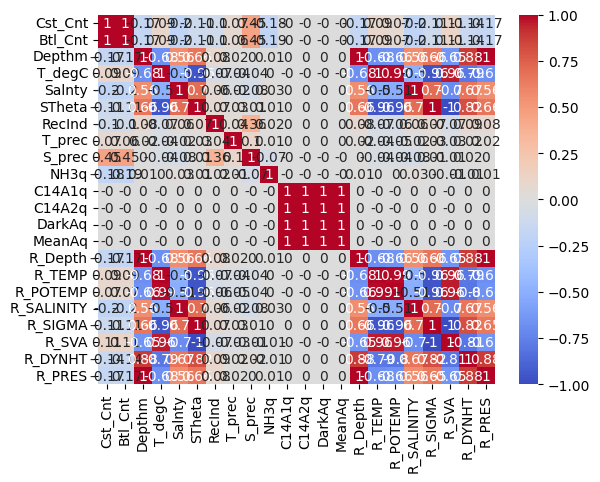

In [22]:
data.displayCorrelation()

##Inference from the correlation matrix


*   There are many features which are not contributing to the T_degC
*   There are many highly dependent features such as CST_Cnt and Btl_Cnt taking any one of it will be enough if required.

###Deleting all features less than absolute 0.1 correlated to a target feature and all features more than 0.8 but not absolute because -ve coorelation contributes in finding pattern.

*   Reducing redundancy from highly positively correlated features to prevent overfitting and multicollinearity.
*   Retaining diverse and complementary information from negatively correlated features, which helps in improving model generalization and predictive accuracy.


In [23]:
#delete columns with correlation less than absolute 0.1 and more than 0.8
data.filterColumnsByCorrelation("T_degC",0.1,False)
data.filterColumnsByCorrelation("T_degC",0.8,True)

,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,STheta,R_Depth,R_SALINITY,R_SIGMA,R_DYNHT,R_PRES
0,133.3 050.0,19-5801ST-HY-021-1842-13330500-0237A-3,237,10.25,34.490,26.516,237.0,34.490,26.51,0.57,238
1,150.0 040.0,19-5509SB-HY-258-1400-15000400-1150A-3,1150,3.76,34.610,27.509,1150.0,34.610,27.50,1.43,1159
2,061.0 055.0,19-5003BD-HY-100-0224-06100550-0600A-7,600,5.27,34.271,27.072,600.0,34.271,27.07,0.86,605
3,140.0 060.0,19-5011BD-HY-325-0300-14000600-0300A-7,300,9.93,34.660,26.705,300.0,34.660,26.70,0.65,302
4,083.3 070.0,19-5902OR-HY-049-1730-08330700-0131A-3,131,9.36,33.640,25.998,131.0,33.640,25.99,0.36,132
...,...,...,...,...,...,...,...,...,...,...,...
197386,086.7 050.0,19-9004JD-PR-114-1933-08670500-0011A-3,11,12.98,33.548,25.273,11.0,33.548,25.27,0.03,11
197387,086.7 100.0,20-0302JD-MX-039-0706-08671000-0144A-3,144,10.26,33.307,25.589,144.0,33.307,25.58,0.47,145
197388,093.3 060.0,19-7412JD-CT-331-0221-09330600-1000A-5,1000,3.85,34.480,27.396,1000.0,34.480,27.39,1.36,1008
197389,119.0 033.0,19-7505JD-CT-157-1109-11900330-0030A-5,30,12.37,33.620,25.448,30.0,33.620,25.44,0.08,30


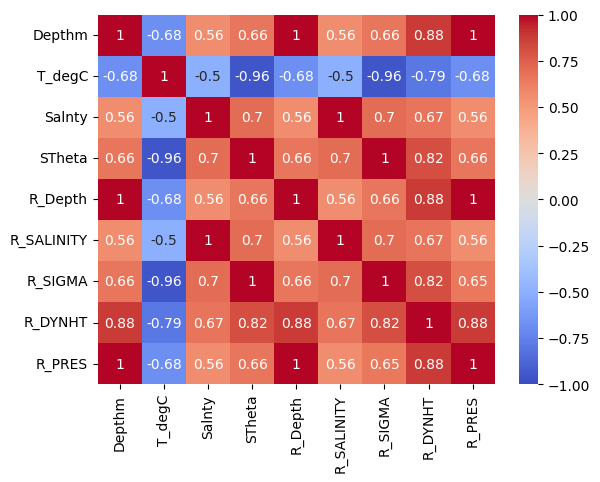

In [24]:
data.displayCorrelation()

In [25]:
data.describe()


,data_type,mean,median,mode,min,Q1,Q2,Q3,max,uniques
Sta_ID,object,None,None,None,None,None,None,None,None,2475
Depth_ID,object,None,None,None,None,None,None,None,None,197391
Depthm,int64,227.92223,125.0,10,0,49.0,125.0,300.0,5351,None
T_degC,float64,10.807038,10.06,9.22,1.44,7.7,10.06,13.89,31.12,None
Salnty,float64,33.840978,33.864,33.58,29.402,33.487,33.864,34.197,36.635,None
STheta,float64,25.816669,25.994,26.984,20.996,24.963,25.994,26.644,28.049,None
R_Depth,float64,227.922813,125.0,10.0,0.0,49.0,125.0,300.0,5351.0,None
R_SALINITY,float64,33.84096,33.864,33.58,29.402,33.487,33.864,34.197,36.635,None
R_SIGMA,float64,25.808822,25.98,26.61,20.99,24.95,25.98,26.64,27.82,None
R_DYNHT,float64,0.432181,0.34,0.0,0.0,0.138,0.34,0.64,3.72,None


## New Inferences by data description and new coorelation


*   "R_Depth", "R_SALINITY","R_PRES","Salnty" and "R_DYNHT" are highly dependent on each other so they are redundant and can cause overfitting.
*   Depth_ID column have number of uniques = totol number of data poins so there is no pattern at all.
*   There are outliers in many columns we can see diffrence by checking quartiles



In [26]:
#removing 4 out of 5 inter dependent column and Depth_ID as it is not contributing to learn any pattern
data.df.drop(columns=["R_Depth", "R_SALINITY","R_PRES","R_DYNHT","Depth_ID"], inplace=True)

In [27]:
data.dataMissingPercentage()

,data_type,mean,median,mode,min,Q1,Q2,Q3,max,uniques,missing_percent
Sta_ID,object,None,None,None,None,None,None,None,None,2475,0.0
Depth_ID,object,None,None,None,None,None,None,None,None,197391,None
Depthm,int64,227.92223,125.0,10,0,49.0,125.0,300.0,5351,None,0.0
T_degC,float64,10.807038,10.06,9.22,1.44,7.7,10.06,13.89,31.12,None,0.0
Salnty,float64,33.840978,33.864,33.58,29.402,33.487,33.864,34.197,36.635,None,4.660294
STheta,float64,25.816669,25.994,26.984,20.996,24.963,25.994,26.644,28.049,None,4.908532
R_Depth,float64,227.922813,125.0,10.0,0.0,49.0,125.0,300.0,5351.0,None,None
R_SALINITY,float64,33.84096,33.864,33.58,29.402,33.487,33.864,34.197,36.635,None,None
R_SIGMA,float64,25.808822,25.98,26.61,20.99,24.95,25.98,26.64,27.82,None,4.916638
R_DYNHT,float64,0.432181,0.34,0.0,0.0,0.138,0.34,0.64,3.72,None,None


In [28]:
# As it is a ocean data there are many factors affecting Salnty so its better to delete missing rater than imputing it.
# data.deleteRow("Salnty")
for col in data.df.columns:
  print(data.results.loc[col,"missing_percent"] >0,data.results.loc[col,"missing_percent"] )
  if data.results.loc[col,"missing_percent"] >0:
    data.deleteRow(col)

data.dataMissingPercentage()

False 0.0
False 0.0
False 0.0
True 4.660293529086939
True 4.908531797295723
True 4.916637536665806


,data_type,mean,median,mode,min,Q1,Q2,Q3,max,uniques,missing_percent
Sta_ID,object,None,None,None,None,None,None,None,None,2475,0.0
Depth_ID,object,None,None,None,None,None,None,None,None,197391,None
Depthm,int64,227.92223,125.0,10,0,49.0,125.0,300.0,5351,None,0.0
T_degC,float64,10.807038,10.06,9.22,1.44,7.7,10.06,13.89,31.12,None,0.0
Salnty,float64,33.840978,33.864,33.58,29.402,33.487,33.864,34.197,36.635,None,0.0
STheta,float64,25.816669,25.994,26.984,20.996,24.963,25.994,26.644,28.049,None,0.0
R_Depth,float64,227.922813,125.0,10.0,0.0,49.0,125.0,300.0,5351.0,None,None
R_SALINITY,float64,33.84096,33.864,33.58,29.402,33.487,33.864,34.197,36.635,None,None
R_SIGMA,float64,25.808822,25.98,26.61,20.99,24.95,25.98,26.64,27.82,None,0.0
R_DYNHT,float64,0.432181,0.34,0.0,0.0,0.138,0.34,0.64,3.72,None,None


In [29]:
# from previous inference we found outliers so we are removing outlies using Inter Quartile Range.
data.removeOutliersIQR()

,Sta_ID,Depthm,T_degC,Salnty,STheta,R_SIGMA
0,133.3 050.0,237,10.25,34.490,26.516,26.51
2,061.0 055.0,600,5.27,34.271,27.072,27.07
3,140.0 060.0,300,9.93,34.660,26.705,26.70
4,083.3 070.0,131,9.36,33.640,25.998,25.99
5,093.3 070.0,200,8.68,34.000,26.389,26.38
...,...,...,...,...,...,...
187221,093.3 080.0,10,16.23,33.510,24.551,24.55
187222,086.7 050.0,11,12.98,33.548,25.273,25.27
187223,086.7 100.0,144,10.26,33.307,25.589,25.58
187225,119.0 033.0,30,12.37,33.620,25.448,25.44


##Encoding
There is only one column (Sta_ID) which needs encoding but it have alot of categories so I am using integer encoding to convert object data into numerical data.

In [30]:
def integerEncoding(columns,df):

  for col in columns:
    category = df[col].unique()
    for i in range(len(category)):
      df.loc[df[col] == category[i] ,col+"_Encoded" ] = i+1
      # df[df[col] == category[i]] =i+1
  return df

corrected_data = integerEncoding(["Sta_ID"],data.df)
corrected_data

,Sta_ID,Depthm,T_degC,Salnty,STheta,R_SIGMA,Sta_ID_Encoded
0,133.3 050.0,237,10.25,34.490,26.516,26.51,1.0
2,061.0 055.0,600,5.27,34.271,27.072,27.07,2.0
3,140.0 060.0,300,9.93,34.660,26.705,26.70,3.0
4,083.3 070.0,131,9.36,33.640,25.998,25.99,4.0
5,093.3 070.0,200,8.68,34.000,26.389,26.38,5.0
...,...,...,...,...,...,...,...
187221,093.3 080.0,10,16.23,33.510,24.551,24.55,266.0
187222,086.7 050.0,11,12.98,33.548,25.273,25.27,104.0
187223,086.7 100.0,144,10.26,33.307,25.589,25.58,219.0
187225,119.0 033.0,30,12.37,33.620,25.448,25.44,434.0


In [31]:
corrected_data["Sta_ID_Encoded"].nunique()
data.describe()

,data_type,mean,median,mode,min,Q1,Q2,Q3,max,uniques,missing_percent
Sta_ID,object,None,None,None,None,None,None,None,None,2316,0.0
Depthm,int64,168.292255,118.0,10,0,41.0,118.0,250.0,678,None,0.0
T_degC,float64,11.175627,10.38,8.4,3.65,8.19,10.38,14.05,23.06,None,0.0
Salnty,float64,33.796237,33.804,33.58,32.469,33.47,33.804,34.14,35.145,None,0.0
STheta,float64,25.738664,25.897,26.984,22.802,24.93,25.897,26.566,27.27,None,0.0
R_SIGMA,float64,25.734698,25.89,26.61,22.8,24.93,25.89,26.56,27.27,None,0.0


##Functions to train a model:


*   init_param(n_features) : used for initializing Weight and bias.
*   compute(W,b,X) : takes feature matrix, weights and bias to calculate predicted value.
* loss(y_true,y_pred) : it used mean sqare error (L2 regularizarion / Ridge regularization) to calculate the loss.
* updated_params(W,b,learning_rate,dw,db) : used for updatting weights and bias based on loss and learining rate.
* generate_polynomial_features(X,degree): takes degree of polynomial and creates new feature matrix for it.
* train(X, y, learning_rate, epochs, degree=1, tolerance=1e-4, decay=0.99) : train the model by taking traing set , learning rate , epoch and degree of polynomial till 2 degree.
* predict(X,W,b,degree=1) : predict on test set using W and b from traning set.
* r_squared(y_true, y_pred) : it is a statistical measure used to assess the goodness of fit of a regression model. (1 means perfect fit , <=0 means poor fit)
* match_percentage(y_true,y_pred, tolerance=0.1): checks how many of the predicted matched actual for a given tolerance.



In [38]:


def init_params(n_features):
    W = np.random.randn(n_features) * 0.01
    b = 0
    return W, b

def compute(W, b, X):
    return np.dot(X, W) + b

def loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def update_params(W, b, learning_rate, dw, db):
    W -= learning_rate * dw
    b -= learning_rate * db
    return W, b

def normalize(X):
    X_mean = np.mean(X, axis=0)
    X_std = np.std(X, axis=0)
    X_normalized = (X - X_mean) / X_std
    return X_normalized, X_mean, X_std

def train(X, y, learning_rate, epochs, tolerance=1e-4, decay=0.99, reg_lambda=0.001):

    X, X_mean, X_std = normalize(X)
    X_poly = X.astype(np.float64)
    y = y.astype(np.float64)

    W, b = init_params(X_poly.shape[1])
    prev_loss = float('inf')

    for i in range(epochs):
        y_pred = compute(W, b, X_poly)
        current_loss = loss(y, y_pred)

        reg_loss = current_loss + reg_lambda * np.sum(W ** 2)

        dw = (2 * np.dot(X_poly.T, (y_pred - y)) + 2 * reg_lambda * W) / X_poly.shape[0]
        db = 2 * np.sum(y_pred - y) / X_poly.shape[0]

        W, b = update_params(W, b, learning_rate, dw, db)
        learning_rate *= decay

        if abs(prev_loss - reg_loss) < tolerance:
            print(f"Early stopping at epoch {i} with loss {reg_loss}")
            break

        prev_loss = reg_loss

        if i % 100 == 0:
            print(f"Epoch {i}, Loss: {reg_loss}")
    return W, b, X_mean, X_std

def predict(X, W, b, degree=1, X_mean=None, X_std=None):
    if X_mean is not None and X_std is not None:
        X = (X - X_mean) / X_std

    X_poly = X
    return compute(W, b, X_poly)

def r_squared(y_true, y_pred):
    ss_total = np.sum((y_true - np.mean(y_true)) ** 2)
    ss_residual = np.sum((y_true - y_pred) ** 2)
    return 1 - (ss_residual / ss_total)

def match_percentage(y_true, y_pred, tolerance=0.1):
    differences = np.abs(y_true - y_pred)
    within_tolerance = differences <= (tolerance * np.abs(y_true))
    return np.mean(within_tolerance) * 100


##Shuffling and Splitting


1.   Shuffiling the data using randon_state =42 and resetting the index
2.   Splitting the data by using created function by providing percent of test_size split.



In [39]:
def train_test_split(X, y, test_size=0.2):
    split_index = int(len(X) * (1 - test_size))

    X_train = X[:split_index].to_numpy()
    X_test = X[split_index:].to_numpy()
    y_train = y[:split_index].to_numpy()
    y_test = y[split_index:].to_numpy()

    return X_train, X_test, y_train, y_test

In [48]:
df_shuffled = corrected_data.sample(frac=1, random_state=42).reset_index(drop=True)
X= df_shuffled[['Depthm','Salnty','Sta_ID_Encoded',"STheta","R_SIGMA"]]
y= df_shuffled['T_degC']
X_train,X_test,y_train,y_test = train_test_split(X,y,0.2)
X

,Depthm,Salnty,Sta_ID_Encoded,STheta,R_SIGMA
0,169,33.820,88.0,26.178,26.170
1,62,33.591,32.0,25.702,25.700
2,579,34.366,182.0,27.046,27.040
3,110,33.390,99.0,25.228,25.220
4,0,33.490,266.0,25.029,25.020
...,...,...,...,...,...
175017,20,33.565,365.0,24.386,24.380
175018,250,34.178,11.0,26.601,26.601
175019,0,34.104,390.0,24.535,24.530
175020,10,33.249,1098.0,24.562,24.560


In [49]:
deg = 1

W, b, X_mean, X_std = train(X_train, y_train, learning_rate=0.1, epochs=1000)


y_pred = predict(X_test, W, b, X_mean=X_mean, X_std=X_std)

print("R-squared:", r_squared(y_test, y_pred))

print("Match percentage with tolerance of 0.1 : ", match_percentage(y_test,y_pred,0.1))

Epoch 0, Loss: 139.22015568252442
Early stopping at epoch 84 with loss 0.0759881561131703
R-squared: 0.9956544943823727
Match percentage with tolerance of 0.1 :  99.46579060134266


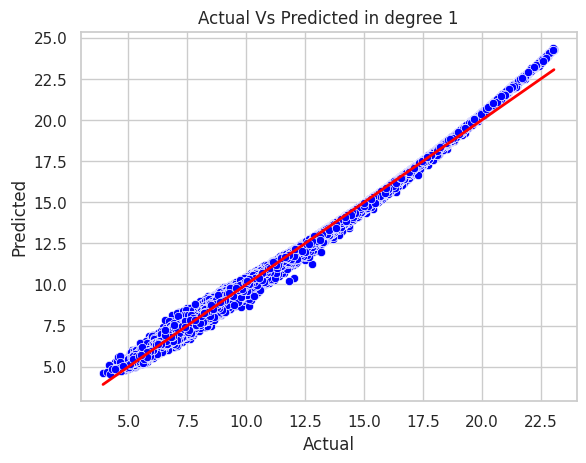

In [50]:
def plot_actual_vs_predicted(y_true, y_pred):
    sns.set(style='whitegrid')

    data = pd.DataFrame({'Actual': y_true, 'Predicted': y_pred})

    # Scatter plot for actual vs predicted
    p = sns.scatterplot(x='Actual', y='Predicted', data=data, color='blue')

    # Perfect prediction line
    sns.lineplot(x=[min(y_true), max(y_true)], y=[min(y_true), max(y_true)], color='red', lw=2)
    p.set_title(f"Actual Vs Predicted in degree {deg}")



def plot_residuals_with_tolerance(y_true, y_pred, tolerance=0.1):

    residuals = y_true - y_pred

    data = pd.DataFrame({'Predicted': y_pred, 'Residuals': residuals})

    sns.set(style='whitegrid')
    p=sns.scatterplot(x='Predicted', y='Residuals', data=data, color='green')
    #Zero residual line
    sns.lineplot(x=[min(y_pred), max(y_pred)], y=[0, 0], color='red', lw=2)

    upper_tolerance = tolerance * abs(y_true)
    lower_tolerance = -tolerance * abs(y_true)

    sns.lineplot(x=[min(y_pred), max(y_pred)], y=[np.mean(upper_tolerance), np.mean(upper_tolerance)], color='blue', lw=2, linestyle='--', label='Upper Tolerance')
    sns.lineplot(x=[min(y_pred), max(y_pred)], y=[np.mean(lower_tolerance), np.mean(lower_tolerance)], color='orange', lw=2, linestyle='--', label='Lower Tolerance')
    p.set_title("Predicted vs residual")


plot_actual_vs_predicted(y_test, y_pred)


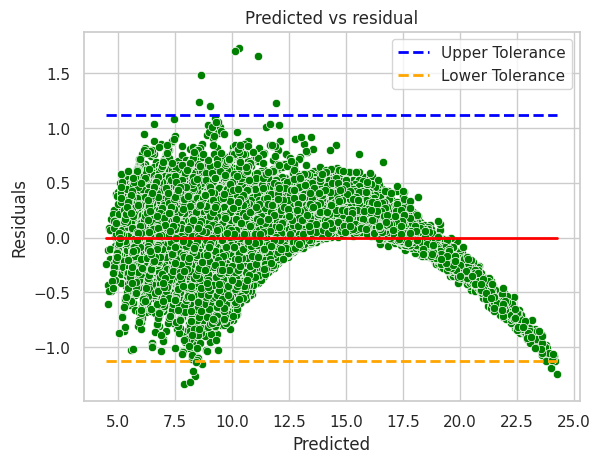

In [47]:
plot_residuals_with_tolerance(y_test, y_pred, tolerance=0.1)